### Importing libraries and defining functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import re
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud 
import joblib

In [2]:
def clean_text(text):
    text = re.sub(r'[#@&][\S]+', '', str(text)) #remove hashtags, callouts, and character references
    text = re.sub(r"[^\w\s]",'',text) #remove special characters
    text = re.sub(r"https\S+",'',text) #remove links
    text = re.sub(r"\s+",' ',text).strip() #fix spaces
    return text.lower()

def get_all_string(sentences): 
    sentence = ''
    for words in sentences:
        sentence += str(words)
    sentence = clean_text(sentence)
    return sentence 

def get_word(sentence):
    return nltk.RegexpTokenizer(r'\w+').tokenize(sentence)

def remove_stopword(word_tokens):
    extra_word = [] #['dell','laptop','new','one']
    stopword_list = stopwords.words('english') + extra_word
    filtered_tokens = []
    
    for word in word_tokens:
        if word not in stopword_list: 
            filtered_tokens.append(word) 
    return filtered_tokens 

def preprocess(series):
    all_string = get_all_string(series)
    words = get_word(all_string)
    filtered_tokens = remove_stopword(words)
    return filtered_tokens

### Loading Dataset

In [3]:
cols = ['tweet_id','entity','sentiment','Text']

df = pd.read_csv('../data/twitter_training.csv', header=None)
df.columns=cols

In [4]:
df.head()

,tweet_id,entity,sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


### EDA

In [5]:
df.groupby('sentiment').describe()

tweet_id                                                   \
              count         mean          std   min      25%     50%   
sentiment                                                              
Irrelevant  12990.0  5928.771363  3616.510316   5.0  2942.00  5153.0   
Negative    22542.0  6760.267767  3479.188211   1.0  3825.00  7105.0   
Neutral     18318.0  6494.270881  3959.853892   3.0  3173.00  6904.0   
Positive    20832.0  6337.924827  3850.925866  12.0  2754.75  6000.5   

                               
                 75%      max  
sentiment                      
Irrelevant   9369.00  13200.0  
Negative     9384.00  13194.0  
Neutral     10011.00  13197.0  
Positive     9707.75  13198.0

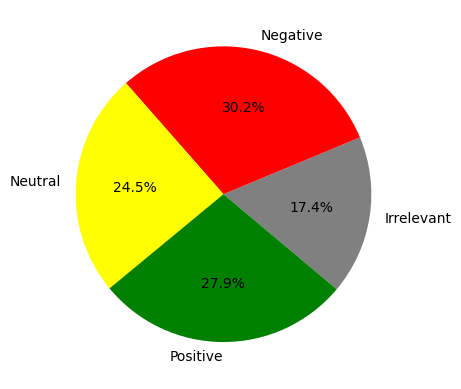

In [6]:
sentiment_counts = df['sentiment'].value_counts().sort_index()

sentiment_labels = ['Irrelevant', 'Negative', 'Neutral','Positive']
sentiment_colors = ['gray', 'red', 'yellow','green']

fig, ax = plt.subplots()
ax.pie(sentiment_counts, labels=sentiment_labels, colors=sentiment_colors, autopct='%1.1f%%', startangle=-40)
plt.show()

<Axes: >

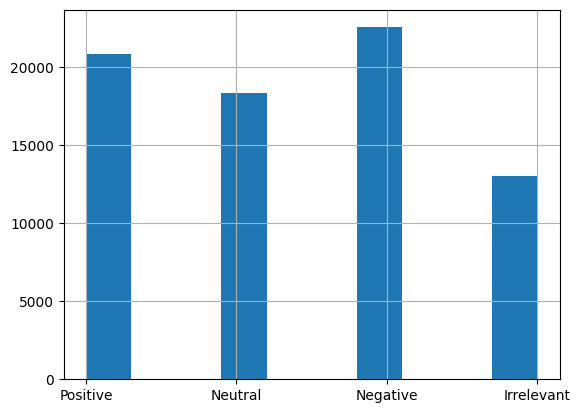

In [7]:
df['sentiment'].hist()

In [8]:
#target_df = (df
# .loc[:,['Text','sentiment']]
 #.assign(Text=lambda x: x['Text'].apply(clean_text))
#)

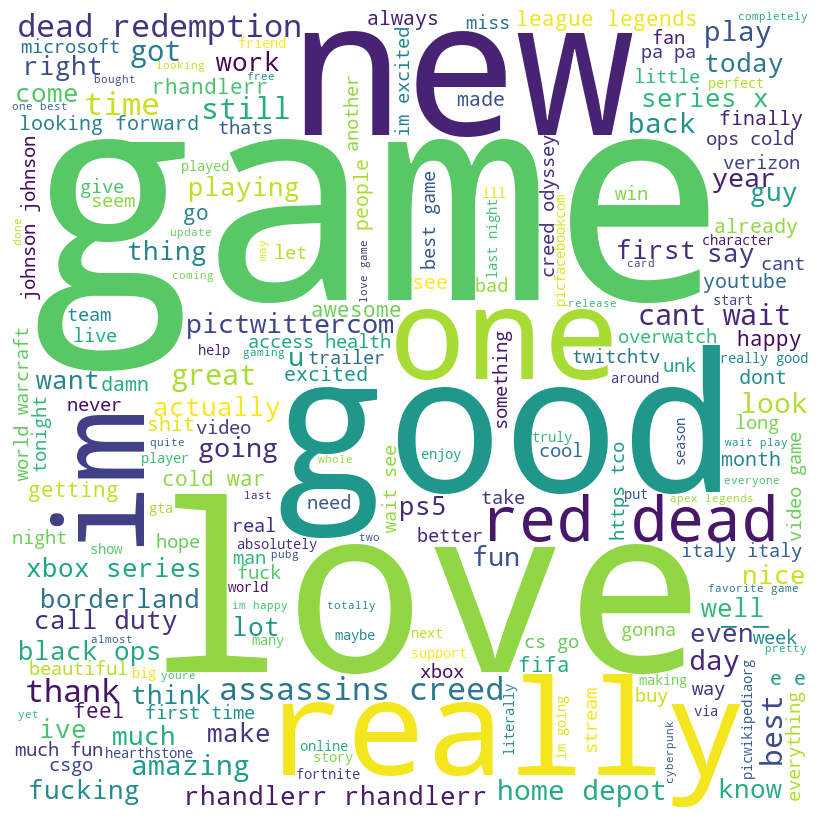

In [9]:
positive_words = preprocess(df.loc[df['sentiment'] == 'Positive']['Text'])

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(' '.join(positive_words))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

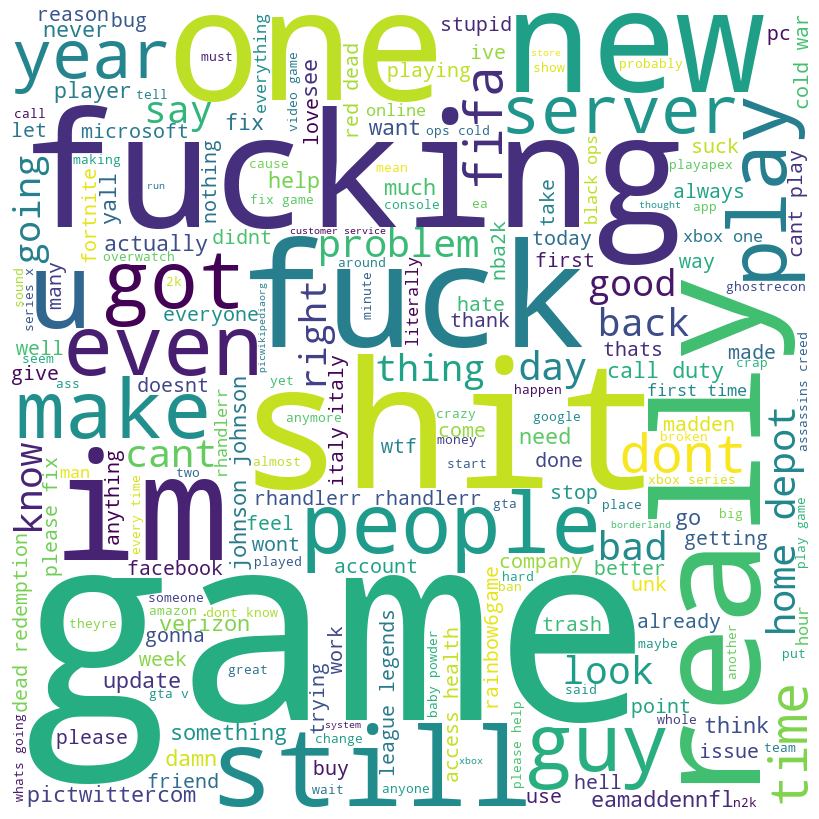

In [10]:
negative_words = preprocess(df.loc[df['sentiment'] == 'Negative']['Text'])

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(' '.join(negative_words))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

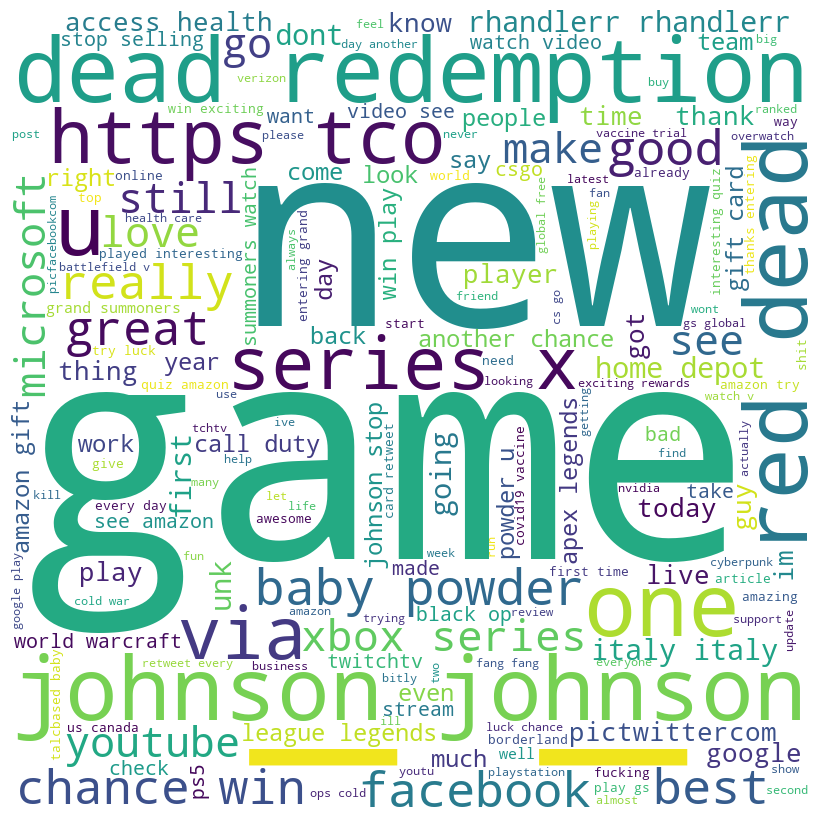

In [11]:
neutral_words = preprocess(df.loc[df['sentiment'] == 'Neutral']['Text'])

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(' '.join(neutral_words))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

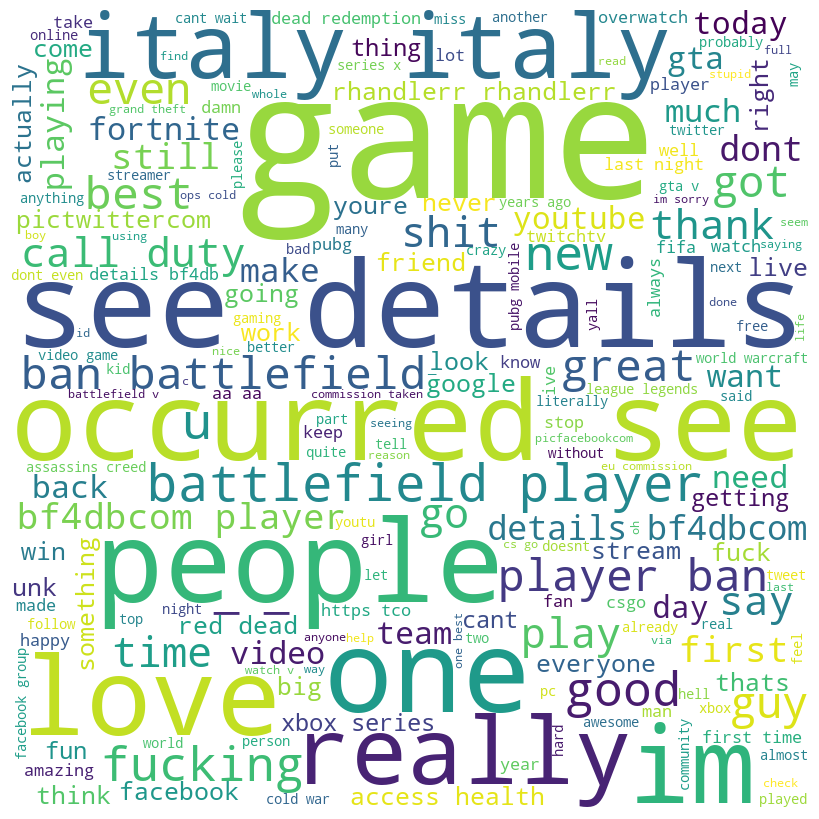

In [12]:
irrelevant_words = preprocess(df.loc[df['sentiment'] == 'Irrelevant']['Text'])

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(' '.join(irrelevant_words))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [13]:
df.isna().sum()

tweet_id       0
entity         0
sentiment      0
Text         686
dtype: int64

### Preprocessing

In [14]:
target_df = (df
 .loc[:,['Text','sentiment']]
 .dropna()
 .assign(Text=lambda x: x['Text'].apply(preprocess))
 .assign(Text=lambda x: x['Text'].apply(' '.join))
)

In [15]:
tf = TfidfVectorizer(max_features=10000,stop_words="english")
X = tf.fit_transform(target_df['Text']).toarray()
lbl = LabelEncoder()
y = lbl.fit_transform(target_df['sentiment'])

In [16]:
x_arr = np.array(X)
y_arr = np.array(y)

In [17]:
X_train,X_test,y_train,y_test = train_test_split(x_arr,y_arr,test_size=0.2,random_state=0)

### Training Models

Naive Bayes

In [18]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

accuracy score : 0.6830


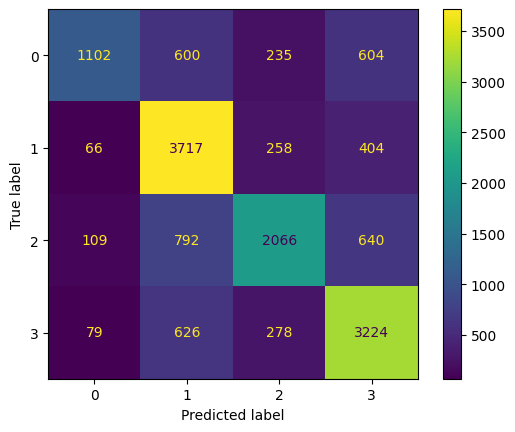

In [19]:
y_pred_nb = nb.predict(X_test)
nb_cnf = confusion_matrix(y_test,y_pred_nb)


print(f"accuracy score : {accuracy_score(y_test,y_pred_nb):.4f}")
ax_nb = ConfusionMatrixDisplay(nb_cnf).plot()
plt.show()

Logistic Regression

In [20]:
lg = LogisticRegression(solver='saga',max_iter=1000, random_state=11)
lg.fit(X_train,y_train)

LogisticRegression(max_iter=1000, random_state=11, solver='saga')

In [21]:
lg.score(X_test,y_test)

0.7275675675675676

accuracy score : 0.7276


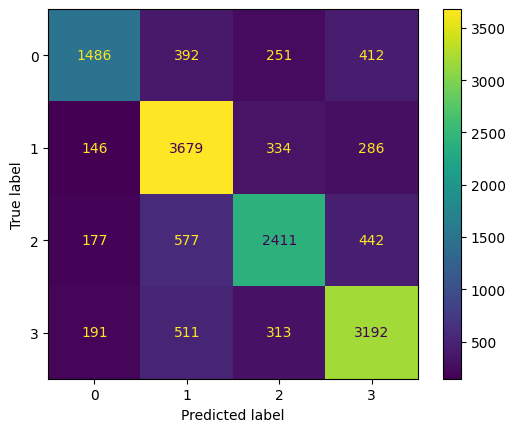

In [22]:
y_pred_lg = lg.predict(X_test)
lg_cnf = confusion_matrix(y_test,y_pred_lg)


print(f"accuracy score : {accuracy_score(y_test,y_pred_lg):.4f}")
ax_lg = ConfusionMatrixDisplay(lg_cnf).plot()
plt.show()

Random Forest

In [23]:
rnf = RandomForestClassifier(criterion='entropy', random_state=11)
rnf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', random_state=11)

accuracy score : 0.8834


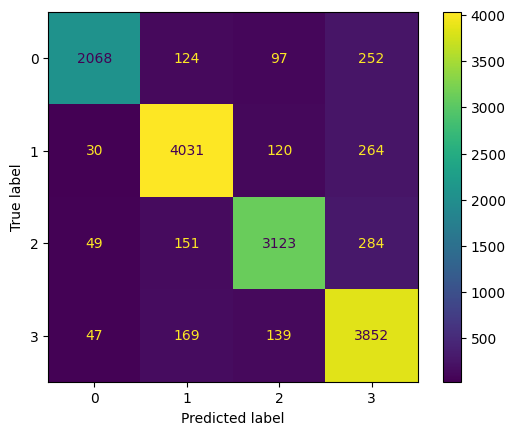

In [24]:
y_pred_rnf = rnf.predict(X_test)
rnf_cnf = confusion_matrix(y_test,y_pred_rnf)


print(f"accuracy score : {rnf.score(X_test,y_test):.4f}")
ax_rnf = ConfusionMatrixDisplay(rnf_cnf).plot()
plt.show()

XGBOOST

In [25]:
xgb = XGBClassifier(random_state=11)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [26]:
xgb.score(X_test,y_test)

0.6256756756756757

accuracy score : 0.6257


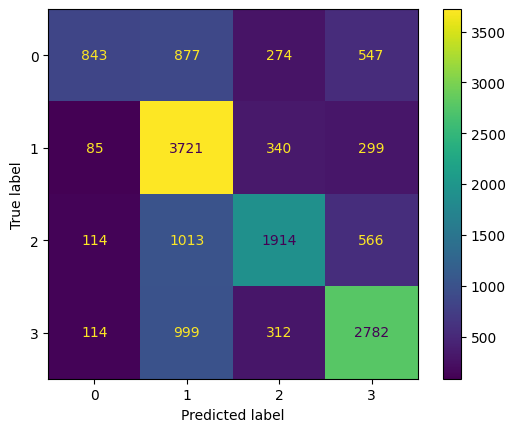

In [27]:
y_pred_xgb = xgb.predict(X_test)
xgb_cnf = confusion_matrix(y_test,y_pred_xgb)


print(f"accuracy score : {xgb.score(X_test,y_test):.4f}")
ax_xgb = ConfusionMatrixDisplay(xgb_cnf).plot()
plt.show()

DecisionTree

In [28]:
dt = DecisionTreeClassifier(random_state=11)
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=11)

In [29]:
dt.score(X_test,y_test)

0.7797972972972973

accuracy score : 0.7798


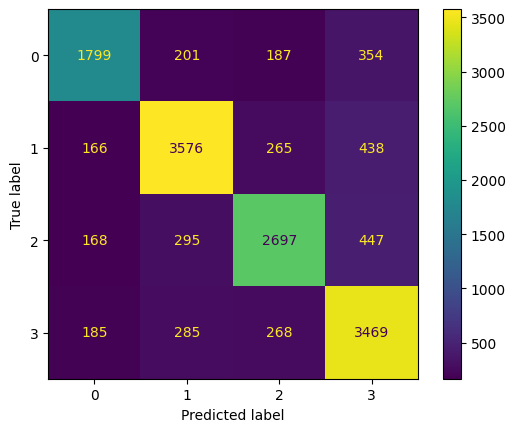

In [30]:
y_pred_dt = dt.predict(X_test)
dt_cnf = confusion_matrix(y_test,y_pred_dt)


print(f"accuracy score : {dt.score(X_test,y_test):.4f}")
ax_dt = ConfusionMatrixDisplay(dt_cnf).plot()
plt.show()

### Testing on validation

In [31]:
val_df = pd.read_csv('../data/twitter_validation.csv', header=None)
val_df.columns=cols

In [32]:
val_target_df = (val_df
 .loc[:,['Text','sentiment']]
 .dropna()
 .assign(Text=lambda x: x['Text'].apply(preprocess))
 .assign(Text=lambda x: x['Text'].apply(' '.join))
)

In [33]:
x_validation = tf.transform(val_target_df['Text']).toarray()
y_validation = lbl.transform(val_target_df['sentiment'])

In [34]:
x_val_arr = np.array(X)
y_val_arr = np.array(y)

accuracy score : 0.9467


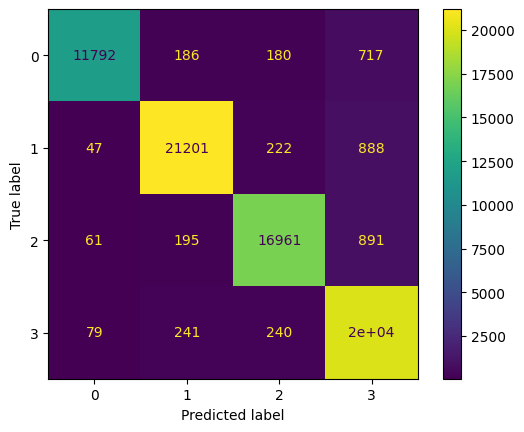

In [35]:
y_val_pred = rnf.predict(x_val_arr)
rnf_cnf_val = confusion_matrix(y_val_arr,y_val_pred)


print(f"accuracy score : {rnf.score(x_val_arr,y_val_arr):.4f}")
ax_rnf_val = ConfusionMatrixDisplay(rnf_cnf_val).plot()
plt.show()

### Testing some tweets

In [36]:
tweet = "great product, I love how it works every day. I need more products like this."
text = ' '.join(preprocess(tweet))

transformed_text = tf.transform([text]).toarray()
prediction = rnf.predict(transformed_text)
sentiment = lbl.inverse_transform(prediction)
print(f'Sentiment for tweet is "{sentiment}"')

Sentiment for tweet is "['Positive']"


In [37]:
tweet = "I can't believe you made this product, It's the worst I've ever tried."
text = ' '.join(preprocess(tweet))

transformed_text = tf.transform([text]).toarray()
prediction = rnf.predict(transformed_text)
sentiment = lbl.inverse_transform(prediction)
print(f'Sentiment for tweet is "{sentiment}"')

Sentiment for tweet is "['Negative']"


### Saving Transformers and Model

In [38]:
joblib.dump(tf, 'tfidfVectorizer.pkl')
joblib.dump(lbl, 'labelEncoder.pkl')
joblib.dump(rnf, 'randomForestmodel.pkl')
joblib.dump(rnf, 'randomForestmodelcompressed.pkl', compress=3)

['randomForestmodelcompressed.pkl']

In [39]:
print(f"TFidfVectorizer size: {np.round(os.path.getsize('tfidfVectorizer.pkl') / 1024 / 1024, 2) } MB")
print(f"Label Encoder size: {np.round(os.path.getsize('labelEncoder.pkl') / 1024 / 1024, 2) } MB")
print(f"Random Forest size: {np.round(os.path.getsize('randomForestmodel.pkl') / 1024 / 1024, 2) } MB")
print(f"Random Forest compressed size: {np.round(os.path.getsize('randomForestmodelcompressed.pkl') / 1024 / 1024, 2) } MB")

TFidfVectorizer size: 0.79 MB
Label Encoder size: 0.0 MB
Random Forest size: 336.26 MB
Random Forest compressed size: 59.12 MB
